# Predicción de ventas para productos alimenticios que se venden en distintas tiendas.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import arange
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor

In [44]:
data = pd.read_csv('/content/drive/MyDrive/Data Science CodingDojo/proyecto 1/sales_predictions.csv')
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


**Objetivo del análisis: Aumentar las ventas**



Descripción de las columnas del DataFrame:


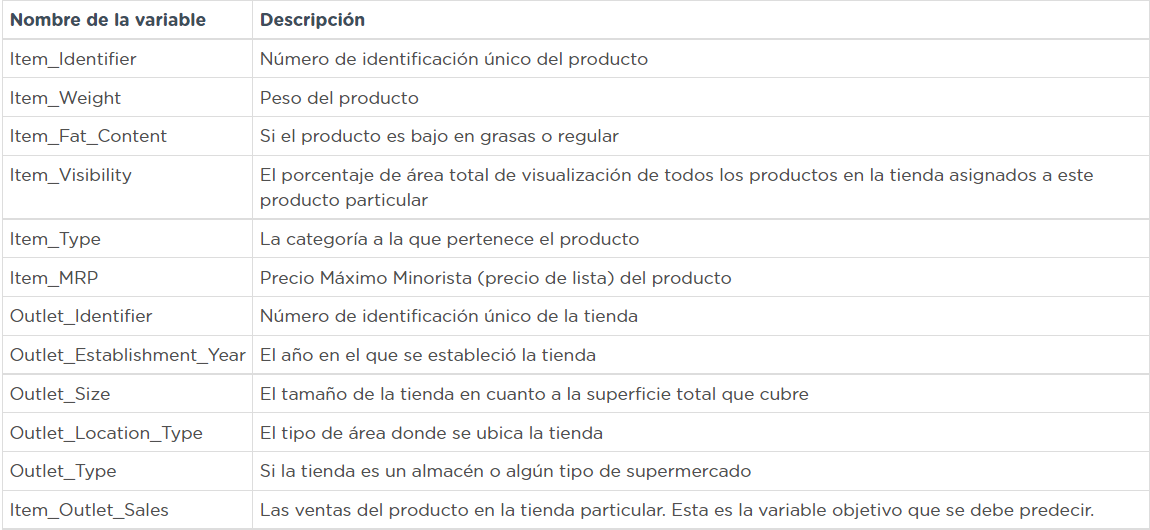

## Limpieza de datos

In [46]:
df = data.copy()

In [47]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [48]:
#Buscar datos duplicados
df.duplicated().sum()

0

In [49]:
#Buscar datos faltantes
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Los datos faltantes se encuentran en las columnas:

*   Item_Weight
*   Outlet_Size



### Análisis de datos faltantes en la columna 'Item_Weight'

> Al revisar las columnas y los datos, se puede observar que la columna 'Item_Identifier' es un identificador de producto, donde el valor del dato perteneciente a la columna 'Item_ Weight' es el mismo para todos los que tienen el mismo identificador.



In [50]:
#Ejemplo
ID = df['Item_Identifier'] == 'FDA15'
filtro = df.loc[ID, :]
filtro

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.3,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
831,FDA15,9.3,Low Fat,0.016055,Dairy,250.2092,OUT045,2002,NaN,Tier 2,Supermarket Type1,5976.2208
2599,FDA15,9.3,Low Fat,0.016019,Dairy,248.5092,OUT035,2004,Small,Tier 2,Supermarket Type1,6474.2392
2643,FDA15,9.3,Low Fat,0.016088,Dairy,249.6092,OUT018,2009,Medium,Tier 3,Supermarket Type2,5976.2208
4874,FDA15,9.3,Low Fat,0.026818,Dairy,248.9092,OUT010,1998,NaN,Tier 3,Grocery Store,498.0184
5413,FDA15,9.3,Low Fat,0.016009,Dairy,250.6092,OUT013,1987,High,Tier 3,Supermarket Type1,6474.2392
6696,FDA15,NaN,Low Fat,0.015945,Dairy,249.5092,OUT027,1985,Medium,Tier 3,Supermarket Type3,6474.2392
7543,FDA15,9.3,LF,0.016113,Dairy,248.8092,OUT017,2007,NaN,Tier 2,Supermarket Type1,5976.2208


> Como se puede observar en este ejemplo, todos los datos que tienen el mismo Item_Identifier (FDA15) tienen como Item_Weight	9.3, por ende, se puede suponer que el dato NaN faltante (index=6696) también tendría que ser de 9.3, ya que pertenece al mismo grupo. Se utilizará esta lógica para completar el resto de los datos faltantes en la columna 'Item_Weight'.



In [51]:
#Agrupar por 'Item_Identifier' y mostrar el valor que corresponde a cada uno de ellos.
id = df.groupby(['Item_Identifier'])[['Item_Weight']].mean()
id

,Item_Weight
Item_Identifier,
DRA12,11.600
DRA24,19.350
DRA59,8.270
DRB01,7.390
DRB13,6.115
...,...
NCZ30,6.590
NCZ41,19.850
NCZ42,10.500


In [52]:
''' Crear un For, el cual recorrerá el dataframe en busca de NaN y luego recorriendo la tabla pivote, creada anteriormente, 
asignar el mismo valor a los que tengan el mismo identificador'''

for x in range(len(df)):
  null1=pd.isnull(df['Item_Weight'][x])
  if (null1==True):
    for y in range(len(id)):
      if(id.index[y]==df['Item_Identifier'][x]):
            df['Item_Weight'][x] = id['Item_Weight'][y]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [53]:
# Mostrar datos faltantes
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     4
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

> Ahora la columna 'Item_Weight' solo le faltan 4 datos, los cuales se eliminarán del dataFrame. 

In [54]:
#Eliminar los 4 datos faltantes de la columna 'Item_Weight'
df = df.dropna(subset=['Item_Weight'])

In [55]:
#Mostrar datos faltantes
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

### Análisis de datos faltantes en la columna 'Outlet_Size' 

> No se puede usar la misma lógica que se utilizó en el análisis de la columna 'Item_Weight', a pesar de que hay una columna 'Outlet_Identifier', al agrupar los datos no tenemos otro dato existente con el mismo identificador.




In [56]:
id_2 = df.groupby(['Outlet_Identifier'])[['Outlet_Size']].count()
id_2

,Outlet_Size
Outlet_Identifier,
OUT010,0
OUT013,932
OUT017,0
OUT018,928
OUT019,527
OUT027,932
OUT035,930
OUT045,0
OUT046,930





> Realizar distintas agrupaciones para buscar alguna suposición lógica para reemplazar los datos faltantes:





In [57]:
#filtro para buscar los datos faltantes de la columna 'Outlet_Size'
missing = df['Outlet_Size'].isna()

In [58]:
#Agrupar datos faltantes
df.loc[missing,:].groupby(['Outlet_Type', 'Outlet_Location_Type'])[['Outlet_Location_Type']].count()

,,Outlet_Location_Type
Outlet_Type,Outlet_Location_Type,
Grocery Store,Tier 3,555
Supermarket Type1,Tier 2,1855


> Al agrupar por 'Outlet_Type' los 2.410 datos faltantes están en el tipo de tienda "Grocery Store" 'Tier 3' y "Supermarket Type1" 'Tier 2'



In [59]:
#Agrupar datos existentes 
df.groupby(['Outlet_Type', 'Outlet_Location_Type', 'Outlet_Size'])[['Outlet_Size']].count()

Outlet_Size
Outlet_Type       Outlet_Location_Type Outlet_Size             
Grocery Store     Tier 1               Small                527
Supermarket Type1 Tier 1               Medium               930
                                       Small                930
                  Tier 2               Small                930
                  Tier 3               High                 932
Supermarket Type2 Tier 3               Medium               928
Supermarket Type3 Tier 3               Medium               932

**Análisis:**  Al revisar los datos faltantes de la columna *'Outlet_Size'*, se observa que los datos faltantes están en el tipo de tienda *'Grocery Store'* y *'Supermarket_Type1'.* 
  Al agrupar los datos existentes por *'Outlet_Type'* , *'Outlet_Size'* y *'Outlet_Location_Type'*, se observa que el tamaño de las tiendas *'Grocery Store'*  son todas Small por ende se puede suponer que los 555 datos faltantes de la columna *'Outlet_Size'* del tipo *'Grocery Store'* también son Small. 
  En el caso de los de tipo *'Supermarket_Type1'*, al analizar los datos faltantes y se puede observar que todos los NaN tienen en común que son de *'Tier 2'*, y si observamos los datos existentes que pertenecen a *'Supermarket_type1'* y están localizados en *'Tier 2'* todos son de tamaño Small, por ende, se puede suponer que estos NaN faltantes son de tamaño Small. 

In [60]:
#Cambiar datos faltantes por 'Small'
df['Outlet_Size'] = df.loc[:, 'Outlet_Size'].fillna('Small')

In [61]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [62]:
#Mostrar datos faltantes
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64



> DataFrame sin datos faltantes 



### Unificar datos en la columna 'Item_fat_Content'

Más adelante, en las visualizaciones, se trabajará con la columna 'Item_Fat_Content', la cual tiene más de una manera de especificar si un producto es Regular o bajo en grasa. Se dejará solo Low Fat y Regular para identificar su cantidad de grasa.

In [63]:
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular', 'low fat', 'LF', 'reg'], dtype=object)

In [64]:
#Cambiar low fat por Low Fat
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')

In [65]:
#Cambiar LF por Low Fat
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')

In [66]:
#Cambiar reg por Regular
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

In [67]:
#Mostar categorías de la columna 'Item_Fat_Content'
df['Item_Fat_Content'].unique()

array(['Low Fat', 'Regular'], dtype=object)

## Visualizaciones

**Análisis del tipo de tienda que más vende:**

In [68]:
df['Outlet_Type'].unique()

array(['Supermarket Type1', 'Supermarket Type2', 'Grocery Store',
       'Supermarket Type3'], dtype=object)

In [69]:
ventas_type_store= df.groupby(by='Outlet_Type')['Item_Outlet_Sales'].sum().sort_values(ascending= False)
ventas_type_store

Outlet_Type
Supermarket Type1    1.291734e+07
Supermarket Type3    3.444468e+06
Supermarket Type2    1.851823e+06
Grocery Store        3.679138e+05
Name: Item_Outlet_Sales, dtype: float64

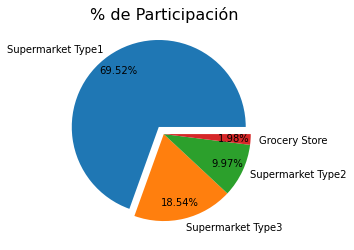

In [70]:
destacar= [0.1, 0, 0, 0]
plt.pie(ventas_type_store.values, labels= ventas_type_store.index, autopct="%.2f%%", pctdistance= 0.8, explode= destacar);
plt.title('% de Participación', fontsize = 16);


> Las tiendas que participan más en ventas son las tiendas clasificadas como Supermarket Type1.




**Análisis de ventas con respecto al tipo de producto.**



In [71]:
ventas_itemtype =df.groupby(by='Item_Type')['Item_Outlet_Sales'].sum().sort_values(ascending= False)
ventas_itemtype

Item_Type
Fruits and Vegetables    2.820060e+06
Snack Foods              2.728352e+06
Household                2.055494e+06
Frozen Foods             1.824165e+06
Dairy                    1.519141e+06
Canned                   1.444151e+06
Baking Goods             1.265405e+06
Health and Hygiene       1.045200e+06
Meat                     9.175656e+05
Soft Drinks              8.928977e+05
Breads                   5.532372e+05
Hard Drinks              4.577934e+05
Starchy Foods            3.514013e+05
Others                   3.255176e+05
Breakfast                2.322990e+05
Seafood                  1.488682e+05
Name: Item_Outlet_Sales, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


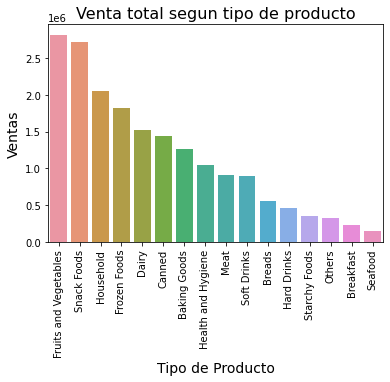

In [72]:
sns.barplot(ventas_itemtype.index, ventas_itemtype.values);
plt.title('Venta total segun tipo de producto', fontsize = 16);
plt.xticks(rotation =90);
plt.xlabel('Tipo de Producto', fontsize = 14);
plt.ylabel('Ventas', fontsize = 14);

> Este grafico muestra cuales son los tipos de productos más vendidas, considerando los datos de todas las tiendas.




**Análisis de Supermarket Type1:** 


*   Considerando que los Supermarket Type1 son los con mayor venta, se analizará la venta de los productos regulares y bajo en grasas de esta categoría de tienda.

Se creará una nueva columna con las cantidades de productos vendidos por tienda 

In [73]:
df['sold_units'] = df['Item_Outlet_Sales'].values / df['Item_MRP'].values

In [74]:
#Filtros:
Super1 = df['Outlet_Type'] =='Supermarket Type1'
Super2 = df['Outlet_Type'] =='Supermarket Type2'
Super3 = df['Outlet_Type'] =='Supermarket Type3'
Grocery = df['Outlet_Type'] =='Grocery Store'

Low_Fat = df['Item_Fat_Content']=='Low Fat'

In [75]:
Low_super1= df.loc[Super1 & Low_Fat,:].groupby(['Item_Identifier'])['sold_units'].mean().sort_values(ascending= False).head(10)
Reg_super1= df.loc[Super1 & ~Low_Fat,:].groupby(by= 'Item_Identifier')['sold_units'].mean().sort_values(ascending= False).head(10)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(0.0, 40.0)

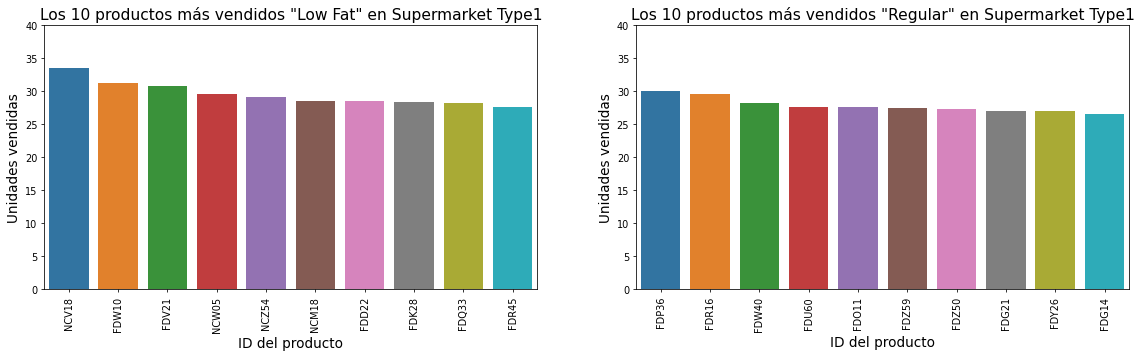

In [76]:
fig = plt.figure(figsize=(20,5), dpi=70)
#Subplot 1
plt.subplot(1, 2, 1);
sns.barplot(Low_super1.index, Low_super1.values);
plt.title('Los 10 productos más vendidos "Low Fat" en Supermarket Type1', fontsize = 16);
plt.xticks(rotation =90);
plt.xlabel('ID del producto', fontsize = 14);
plt.ylabel('Unidades vendidas', fontsize = 14);
plt.ylim(bottom=0,top=40)
#Subplot 2
plt.subplot(1, 2, 2);
sns.barplot(Reg_super1.index, Reg_super1.values);
plt.title('Los 10 productos más vendidos "Regular" en Supermarket Type1', fontsize = 16);
plt.xticks(rotation =90);
plt.xlabel('ID del producto', fontsize = 14);
plt.ylabel('Unidades vendidas', fontsize = 14);
plt.ylim(bottom=0,top=40)

> Este grafico muestra los 10 productos más vendidos, en la categoría Low Fat y Regular en un Supermarket Type1.



##Análisis Estadístico

In [77]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,sold_units
count,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000,8519.000000
mean,12.875420,0.066112,141.010019,1997.837892,2181.188779,15.421798
std,4.646098,0.051586,62.283594,8.369105,1706.511093,9.186985
min,4.555000,0.000000,31.290000,1985.000000,33.290000,0.952322
25%,8.785000,0.026983,93.844900,1987.000000,834.247400,8.949479
50%,12.650000,0.053925,143.047000,1999.000000,1794.331000,14.926893
75%,16.850000,0.094558,185.676600,2004.000000,3100.630600,21.089168
max,21.350000,0.328391,266.888400,2009.000000,13086.964800,56.844890


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


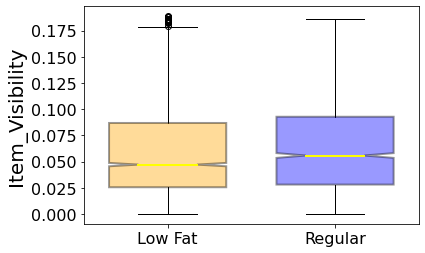

In [78]:
#filtros
Visibility_LF = df.loc[Super1 & Low_Fat,:]['Item_Visibility']
Visibility_Reg = df.loc[Super1 & ~Low_Fat,:]['Item_Visibility']

#grafico
fig, axes = plt.subplots(nrows = 1, ncols = 1)
boxplots = axes.boxplot([Visibility_LF, Visibility_Reg],
           notch = True,
           labels=['Low Fat', 'Regular'],
           widths = .7,
           patch_artist=True,
           medianprops = dict(linestyle='-', linewidth=2, color='Yellow'),
           boxprops = dict(linestyle='--', linewidth=2, color='Black', facecolor = 'blue', alpha = .4)
          );
boxplot1 = boxplots['boxes'][0]
boxplot1.set_facecolor('orange')
plt.ylabel('Item_Visibility', fontsize = 20);
plt.xticks(fontsize = 16);
plt.yticks(fontsize = 16);

> Este diagrama muestra la comparación entre las categorías Low Fat y Regular, en relación al porcentaje de visualización asignado a los productos de estas categorías.



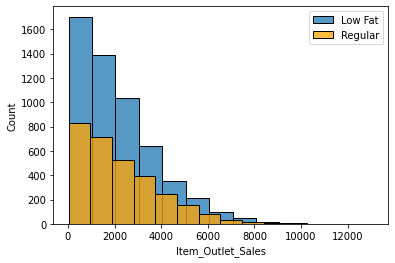

In [79]:
#Filtros
LF = df.loc[Low_Fat,:]
REG = df.loc[~Low_Fat,:]
#Grafico
sns.histplot(LF['Item_Outlet_Sales'], label= 'Low Fat',bins = 13)
sns.histplot(REG['Item_Outlet_Sales'], label= 'Regular', color ='orange', bins = 13)
plt.legend()

> En este grafico de barras se puede observar que se venden mayores cantidades de productos Low Fat que productos Regulares.



In [80]:
#Filtros
small = df['Outlet_Size'] == 'Small'
medium = df['Outlet_Size'] == 'Medium'
high = df['Outlet_Size'] == 'High'

In [84]:
#Filtros
S = df.loc[small,:]
M = df.loc[medium,:]
H = df.loc[high,:]

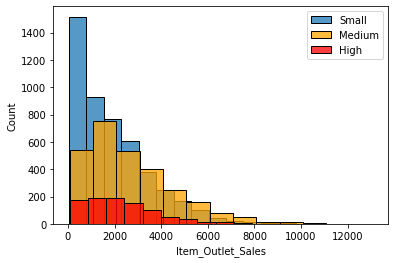

In [85]:
#Grafico
sns.histplot(S['Item_Outlet_Sales'], label= 'Small',bins = 13)
sns.histplot(M['Item_Outlet_Sales'], label= 'Medium', color ='orange', bins = 13)
sns.histplot(H['Item_Outlet_Sales'], label= 'High', color ='red', bins = 13)
plt.legend()

> En este grafico se puede observar que las tiendas que mayor cantidad de ventas tienen son las de tamaño Small, y las que menos cantidad de ventas tienen son las de tamaño High.



## Modelo de predicción

### Datos Categóricos

Se utilizo la siguiente fuente para trabajar con datos categóricos 



*   https://towardsdatascience.com/understanding-feature-engineering-part-2-categorical-data-f54324193e63

In [86]:
#Copia de la data para trabajar los datos categóricos
df2 = df.copy()

In [87]:
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,sold_units
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228,9.186454
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,Small,Tier 3,Grocery Store,732.3800,4.021967
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052,18.467868


In [88]:
# Columna 'Item Type'
type_le = LabelEncoder() 
item_type_labels = type_le.fit_transform(df2['Item_Type']) 
type_mappings = {index: label for index, label in enumerate(type_le.classes_)}
type_mappings

{0: 'Baking Goods',
 1: 'Breads',
 2: 'Breakfast',
 3: 'Canned',
 4: 'Dairy',
 5: 'Frozen Foods',
 6: 'Fruits and Vegetables',
 7: 'Hard Drinks',
 8: 'Health and Hygiene',
 9: 'Household',
 10: 'Meat',
 11: 'Others',
 12: 'Seafood',
 13: 'Snack Foods',
 14: 'Soft Drinks',
 15: 'Starchy Foods'}

In [89]:
df2['Item_Type_Labels'] = item_type_labels

In [90]:
Type_ohe = OneHotEncoder() 
Type_feature_arr = Type_ohe.fit_transform(df2[['Item_Type_Labels']]). toarray () 
Type_feature_labels = list (type_le.classes_) 
Type_features = pd.DataFrame (Type_feature_arr, columns = Type_feature_labels)
Type_features

,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8515,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [91]:
#Columna 'Outlet_Size'
Size_map = {'Small' : 0, 'Medium': 1, 'High': 2}
df2['Outlet_Size_Labels'] = df2['Outlet_Size'].map(Size_map) 

In [92]:
#Columna 'Outlet_Type'
outlet_type_le = LabelEncoder() 
outlet_type_labels = outlet_type_le.fit_transform(df2['Outlet_Type']) 
outlet_type_mappings = {index: label for index, label in enumerate(outlet_type_le.classes_)}
outlet_type_mappings

{0: 'Grocery Store',
 1: 'Supermarket Type1',
 2: 'Supermarket Type2',
 3: 'Supermarket Type3'}

In [93]:
df2['Outlet_Type_Labels'] = outlet_type_labels

In [94]:
#Columna 'Outlet_Location_Type'
Location_Type_le = LabelEncoder() 
Location_Type_labels = Location_Type_le.fit_transform(df2['Outlet_Location_Type']) 
Location_Type_mappings = {index: label for index, label in enumerate(Location_Type_le.classes_)}
Location_Type_mappings

{0: 'Tier 1', 1: 'Tier 2', 2: 'Tier 3'}

In [95]:
df2['Outlet_Location_Type_Labels'] = Location_Type_labels

In [96]:
#Columna 'Item_Fat_Content'
Item_Fat_le = LabelEncoder() 
Item_Fat_labels = Item_Fat_le.fit_transform(df2['Item_Fat_Content']) 
Item_Fat_mappings = {index: label for index, label in enumerate(Item_Fat_le.classes_)}
Item_Fat_mappings

{0: 'Low Fat', 1: 'Regular'}

In [97]:
df2['Item_Fat_Content_Labels'] = Item_Fat_labels

In [98]:
#Concatenar los dataframe
df2 = pd.concat([df2, Type_features], axis= 1)
df2.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,sold_units,Item_Type_Labels,Outlet_Size_Labels,Outlet_Type_Labels,Outlet_Location_Type_Labels,Item_Fat_Content_Labels,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228,9.186454,14.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998.0,Small,Tier 3,Grocery Store,732.3800,4.021967,6.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052,18.467868,9.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
df2.isnull().sum()

Item_Identifier                4
Item_Weight                    4
Item_Fat_Content               4
Item_Visibility                4
Item_Type                      4
Item_MRP                       4
Outlet_Identifier              4
Outlet_Establishment_Year      4
Outlet_Size                    4
Outlet_Location_Type           4
Outlet_Type                    4
Item_Outlet_Sales              4
sold_units                     4
Item_Type_Labels               4
Outlet_Size_Labels             4
Outlet_Type_Labels             4
Outlet_Location_Type_Labels    4
Item_Fat_Content_Labels        4
Baking Goods                   4
Breads                         4
Breakfast                      4
Canned                         4
Dairy                          4
Frozen Foods                   4
Fruits and Vegetables          4
Hard Drinks                    4
Health and Hygiene             4
Household                      4
Meat                           4
Others                         4
Seafood   

In [100]:
#Dataframe que usaremos sin datos faltantes. 
df3 = df2.dropna()
df3.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,sold_units,Item_Type_Labels,Outlet_Size_Labels,Outlet_Type_Labels,Outlet_Location_Type_Labels,Item_Fat_Content_Labels,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,3735.1380,14.951963,4.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009.0,Medium,Tier 3,Supermarket Type2,443.4228,9.186454,14.0,1.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999.0,Medium,Tier 1,Supermarket Type1,2097.2700,14.809346,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998.0,Small,Tier 3,Grocery Store,732.3800,4.021967,6.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987.0,High,Tier 3,Supermarket Type1,994.7052,18.467868,9.0,2.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [101]:
df3.isnull().sum()

Item_Identifier                0
Item_Weight                    0
Item_Fat_Content               0
Item_Visibility                0
Item_Type                      0
Item_MRP                       0
Outlet_Identifier              0
Outlet_Establishment_Year      0
Outlet_Size                    0
Outlet_Location_Type           0
Outlet_Type                    0
Item_Outlet_Sales              0
sold_units                     0
Item_Type_Labels               0
Outlet_Size_Labels             0
Outlet_Type_Labels             0
Outlet_Location_Type_Labels    0
Item_Fat_Content_Labels        0
Baking Goods                   0
Breads                         0
Breakfast                      0
Canned                         0
Dairy                          0
Frozen Foods                   0
Fruits and Vegetables          0
Hard Drinks                    0
Health and Hygiene             0
Household                      0
Meat                           0
Others                         0
Seafood   

In [102]:
#Correlación 
df3.corr().sort_values(by = ['Item_Outlet_Sales'])

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,sold_units,Item_Type_Labels,Outlet_Size_Labels,Outlet_Type_Labels,Outlet_Location_Type_Labels,Item_Fat_Content_Labels,Baking Goods,Breads,Breakfast,Canned,Dairy,Frozen Foods,Fruits and Vegetables,Hard Drinks,Health and Hygiene,Household,Meat,Others,Seafood,Snack Foods,Soft Drinks,Starchy Foods
Item_Visibility,-0.009013,1.000000,-0.001183,-0.074521,-0.128422,-0.160875,-0.035068,-0.094195,-0.173781,-0.028124,0.046651,0.007162,-0.006545,-0.006642,-0.009121,0.017530,-0.009704,-0.003072,-0.007588,-0.016012,0.006908,0.009775,0.003386,-0.004117,-0.001173,0.008918,0.005263
Outlet_Establishment_Year,-0.013135,-0.074521,0.004791,1.000000,-0.048969,-0.073980,0.004570,-0.425724,-0.121699,-0.089148,0.003518,-0.003842,0.003426,-0.005952,-0.004189,0.000356,0.007922,-0.001375,-0.004195,0.009466,-0.006336,-0.011539,-0.005150,0.015033,0.007111,-0.002067,0.003796
Breads,0.002948,-0.006545,-0.002973,0.003426,-0.013019,-0.007663,-0.015001,-0.007275,-0.012542,-0.007090,-0.013752,-0.049976,1.000000,-0.019937,-0.050060,-0.051342,-0.058225,-0.071645,-0.027982,-0.044401,-0.060248,-0.039945,-0.024800,-0.015166,-0.070553,-0.040925,-0.023179
Fruits and Vegetables,0.008624,-0.003072,-0.001416,-0.001375,-0.012623,-0.017390,-0.020645,0.006024,-0.012196,-0.003610,0.017581,-0.117886,-0.071645,-0.047030,-0.118084,-0.121110,-0.137345,1.000000,-0.066006,-0.104735,-0.142118,-0.094225,-0.058499,-0.035775,-0.166424,-0.096536,-0.054675
Health and Hygiene,-0.012201,-0.016012,-0.009125,0.009466,-0.011822,-0.007888,0.008900,0.008905,0.010999,0.006938,-0.016353,-0.073058,-0.044401,-0.029146,-0.073180,-0.075055,-0.085117,-0.104735,-0.040906,1.000000,-0.088075,-0.058394,-0.036254,-0.022171,-0.103138,-0.059826,-0.033884
Starchy Foods,-0.001747,0.005263,0.004983,0.003796,-0.007700,-0.007483,0.033191,-0.006411,-0.001924,0.005876,-0.005945,-0.038139,-0.023179,-0.015215,-0.038202,-0.039181,-0.044434,-0.054675,-0.021354,-0.033884,-0.045978,-0.030484,-0.018926,-0.011574,-0.053842,-0.031231,1.000000
Others,0.008003,0.003386,-0.012450,-0.005150,-0.004477,0.008668,0.027345,0.006964,0.000086,-0.000055,-0.020378,-0.040806,-0.024800,-0.016279,-0.040874,-0.041922,-0.047541,-0.058499,-0.022848,-0.036254,-0.049194,-0.032616,1.000000,-0.012383,-0.057607,-0.033415,-0.018926
Frozen Foods,0.010230,-0.009704,-0.002519,0.007922,-0.003990,-0.006991,-0.007604,0.001022,0.006578,0.003657,0.015268,-0.095805,-0.058225,-0.038220,-0.095965,-0.098425,1.000000,-0.137345,-0.053643,-0.085117,-0.115497,-0.076575,-0.047541,-0.029074,-0.135251,-0.078453,-0.044434
Baking Goods,0.001079,0.007162,-0.021293,-0.003842,-0.003368,0.012146,-0.043993,-0.011386,-0.002147,-0.013604,-0.000952,1.000000,-0.049976,-0.032806,-0.082369,-0.084480,-0.095805,-0.117886,-0.046043,-0.073058,-0.099134,-0.065726,-0.040806,-0.024955,-0.116089,-0.067338,-0.038139
Hard Drinks,0.017263,-0.007588,0.003525,-0.004195,-0.001539,-0.002940,-0.015427,-0.008720,-0.001839,0.008192,-0.017938,-0.046043,-0.027982,-0.018368,-0.046120,-0.047302,-0.053643,-0.066006,1.000000,-0.040906,-0.055507,-0.036801,-0.022848,-0.013973,-0.065000,-0.037704,-0.021354


### Modelos de Regresion

In [103]:
X1 = df3.drop(columns=['Item_Outlet_Sales', 'Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier', 'Outlet_Size',	'Outlet_Location_Type',	'Outlet_Type', 'sold_units'])
y1= df3['Item_Outlet_Sales']

In [105]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=3)

#### Regresión Lineal

In [106]:
reg = LinearRegression(fit_intercept=True)

In [107]:
reg.fit(X1_train,y1_train)

LinearRegression()

In [108]:
score_Reg_test = reg.score(X1_test, y1_test)
print(score_Reg_test)

0.5010025207115034


#### Random Forests



In [118]:
rf = RandomForestRegressor()
rf.fit(X1_train, y1_train)

RandomForestRegressor()

In [120]:
#Testing R2
rf.score(X1_test, y1_test)

0.5670151332592692



> Random Forests dio un mejor resultado en el score.



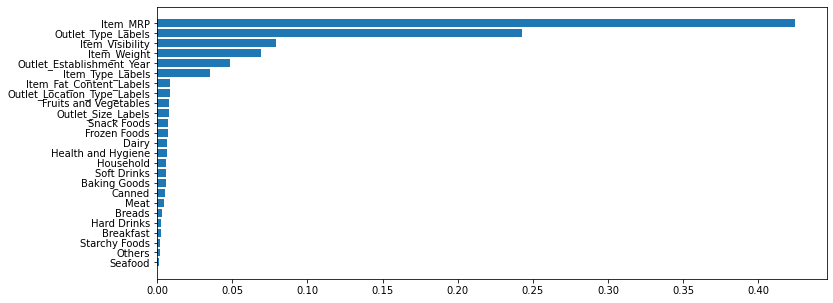

In [135]:
#Columnas que tienen mayor importancia en la predicción
rf_features = pd.DataFrame({'feature' : X1_train.columns, 'feature_importance': rf.feature_importances_})
rf_features.sort_values(by = 'feature_importance', inplace = True)

plt.figure(figsize=(12,5))
plt.barh(rf_features['feature'], rf_features['feature_importance']);

### Métricas (Random Forests)

In [131]:
y1_pre_test = rf.predict(X1_test[:])

In [132]:
#error absoluto medio (MAE) test
mae (y1_test, y1_pre_test)

806.4719127364959

In [133]:
#error cuadrático medio (MSE) test
mse(y1_test, y1_pre_test)

1289451.1628384413

In [134]:
#la raíz del error cuadrático medio (RMSE) test
rmse = np.sqrt(mse(y1_test, y1_pre_test))
rmse

1135.540031367649